# Note sur les cartes cognitives

V2, après nouvelles enquêtes VBO et reprise du thésaurus.


## Notes sur les données

### A l'usage du producteur

Pour faciliter le traitement automatique, assurer la qualité des données

- apostrophe avant date
- espace/majuscules surperflues : respecter l'orthographe, supprimer les articles inutiles, forme fléchies
  - penser à _un dictionnaire_
- colonnes duppliquées (calcul si besoin)
- colonnes de même nom
- colonnes au nom ambigu
- numéro au delà des utilisés
- pas de mise en forme en utilisant des cellules vides

### Notes techniques

- rester tant que possible sur un `DataFrame`,
  - ne pas mixer / casser la srtucture,
  - ou alors, _once and for all_ e.g., pour la liste de réponses,
- assurer la cohérence de la clef : OK (au 2022-05-31)
- gérer les libellés des questions
- la représentation des durées/ages (`ans`)

## Exploration du dataset


In [1]:
import operator as op

from datetime import date
from pathlib import Path
from collections import Counter
from statistics import fmean


import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from catk import CA

FILENAME = Path("../input/BDD_2022-06-01.xlsx")
MAX_COLS = 20
PREFIX_MINE = "Mine"
PREFIX_FUTUR = "Futur"
LABEL_MINE = "la mine et le nickel"
LABEL_FUTUR = "la mine dans le futur"
TOP_K_WORDS = 20

cols_mine = [f"{PREFIX_MINE} {i}" for i in range(1, MAX_COLS + 1)]
cols_futur = [f"{PREFIX_FUTUR} {i}" for i in range(1, MAX_COLS + 1)]
cols_censurees = [f"Question {x}" for x in [2, 5.1, 7, 10.1, 11, 14, 14.1]] + ["Commentaire entretien/individu"]


def clean(s: str) -> str:
    return s.strip().lower()


'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/data/data.py' loaded
'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/data/__init__.py' loaded
'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/ca.py' loaded
'/home/romulus/Documents/unc-informatique.pharmaco-chemistry-biblio/catk/catk/__init__.py' loaded


In [2]:
df_complete = pd.read_excel(FILENAME, sheet_name="BDD", index_col="Numéro")

# ajout des groupes d'age quinquennaux/décénaux
df_complete["GAD"] = 10 * (df_complete["Question 12"] // 10)
df_complete["GAQ"] = 5 * (df_complete["Question 12"] // 5)

print("Liste des colonnes disponibles")
display(df_complete.columns)

cols_resp = [c for c in df_complete.columns if c not in cols_mine + cols_futur + cols_censurees]

df_resp = df_complete[cols_resp]
df_resp.name = "Données personnelles"
df_mine = df_complete[cols_mine].astype("string")
df_mine.name = f"Cartes cognitives '{LABEL_MINE}'"
df_futur = df_complete[cols_futur].astype("string")
df_futur.name = f"Cartes cognitives '{LABEL_FUTUR}'"

print(f"Nombre de répondants {len(df_complete)}")
print(f"Colonnes '{LABEL_MINE}' présentes {set(cols_mine) <= set(df_complete.columns)}")
print(f"Colonnes '{LABEL_FUTUR}' présentes {set(cols_futur) <= set(df_complete.columns)}")


Liste des colonnes disponibles


Index(['Date', 'Commune d’enquête', 'Collecte directe',
       'Commentaire entretien/individu', 'Question 1', 'Question 2',
       'Question 3', 'Question 4', 'Question 5', 'Question 5.1', 'Question 6',
       'Question 7', 'Question 8', 'Question 8.1', 'Question 8.2',
       'Question 9', 'Question 10', 'Question 10.1', 'Question 11',
       'Question 12', 'Question 13', 'Question 14', 'Question 14.1', 'Mine 1',
       'Mine 2', 'Mine 3', 'Mine 4', 'Mine 5', 'Mine 6', 'Mine 7', 'Mine 8',
       'Mine 9', 'Mine 10', 'Mine 11', 'Mine 12', 'Mine 13', 'Mine 14',
       'Mine 15', 'Mine 16', 'Mine 17', 'Mine 18', 'Mine 19', 'Mine 20',
       'Futur 1', 'Futur 2', 'Futur 3', 'Futur 4', 'Futur 5', 'Futur 6',
       'Futur 7', 'Futur 8', 'Futur 9', 'Futur 10', 'Futur 11', 'Futur 12',
       'Futur 13', 'Futur 14', 'Futur 15', 'Futur 16', 'Futur 17', 'Futur 18',
       'Futur 19', 'Futur 20', 'GAD', 'GAQ'],
      dtype='object')

Nombre de répondants 508
Colonnes 'la mine et le nickel' présentes True
Colonnes 'la mine dans le futur' présentes True


In [3]:
# display(df_resp.info())
display(df_resp)


,Date,Commune d’enquête,Collecte directe,Question 1,Question 3,Question 4,Question 5,Question 6,Question 8,Question 8.1,Question 8.2,Question 9,Question 10,Question 12,Question 13,GAD,GAQ
Numéro,,,,,,,,,,,,,,,,,
1,2021-06-09,Thio,Oui,Non,NaN,Oui,Oui,NaN,Thio - St Philippo 2,Thio,Minière,59.0,Oui,59.0,Homme,50.0,55.0
2,2021-06-09,Thio,Oui,Non,NaN,Non,Non,3.0,Thio,Thio,Minière,3.0,Non,63.0,Homme,60.0,60.0
3,2021-06-09,Thio,Oui,Non,NaN,Oui,Oui,NaN,Thio,Thio,Minière,35.0,Non,35.0,Femme,30.0,35.0
4,2021-06-09,Thio,Oui,Oui,15.0,Oui,Oui,NaN,Thio - Mission,Thio,Minière,52.0,Non,52.0,Homme,50.0,50.0
5,2021-06-10,Thio,Oui,Non,NaN,Oui,Oui,NaN,Thio - St Philippo 1,Thio,Minière,50.0,Oui,69.0,Femme,60.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2022-03-10,Hienghène,Oui,Non,NaN,Non,Oui,NaN,Village,Hienghène,Non minière,NaN,Non,14.0,Femme,10.0,10.0
505,2022-03-10,Hienghène,Oui,Non,NaN,Oui,Oui,NaN,Caavatch,Hienghène,Non minière,NaN,Non,13.0,Femme,10.0,10.0
506,2022-03-10,Hienghène,Oui,Non,NaN,Oui,Oui,NaN,Panié,Hienghène,Non minière,NaN,Oui,13.0,Homme,10.0,10.0


In [4]:
display(df_mine)


,Mine 1,Mine 2,Mine 3,Mine 4,Mine 5,Mine 6,Mine 7,Mine 8,Mine 9,Mine 10,Mine 11,Mine 12,Mine 13,Mine 14,Mine 15,Mine 16,Mine 17,Mine 18,Mine 19,Mine 20
Numéro,,,,,,,,,,,,,,,,,,,,
1,Pollution,Inondation,Boom,Travail,Retombée,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Richesse,Malédiction,Travail,Destruction,Histoire,Frein,Blocage,Coutumier,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Travail,Pollution,Plainte,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Argent,Pollution,Nickel,Production,Nature,Réparation,Mer,Inégalité,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,Extraction,Montagne,Pollution,Mineur,Train,Diversité,Évolution,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,Caillou,Camion,Fer,Ramassage,Faire fondre le nickel,Transport,Bâteau,Construire des objets,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
505,Granite,Usine,Richesse,Epuisable,Pétrole,Cailloux,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
506,Exploitation,Richesse,Conflit,Détruit le lagon,Pollution,Argents,Vol d'argent,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [5]:
display(df_futur)


,Futur 1,Futur 2,Futur 3,Futur 4,Futur 5,Futur 6,Futur 7,Futur 8,Futur 9,Futur 10,Futur 11,Futur 12,Futur 13,Futur 14,Futur 15,Futur 16,Futur 17,Futur 18,Futur 19,Futur 20
Numéro,,,,,,,,,,,,,,,,,,,,
1,Fermeture,Usine de Doniambo,Travail,Creusage,Droit,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Impossible,Indispensable,Gestion,Enjeu,Concurrence,Rationnalisation,Entente,Difficile,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Rien,Après-nickel,Pollution,Activité,Épuisement,Rebondissement,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Montagne,Poisson,Dépotoir,Répartition,Rendement,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,Extraction,Tradition,Repère,Action,Adaptation,Pauvre,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,Il aura plus,Pollution,Usine abandonnée,Trop exploité,Camion,Outils de travail,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
505,Epuisé,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
506,Exploitation,Destruction nature,Conflit,Destruction du lagon,Pollution,Terrain trop exploité,Destruction de notre pays,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Quelques vérifications et indicateurs globaux


Création des dictionnaires de réponses sur les deux enquêtes


In [6]:
def get_cogmaps(df, cols):
    return {idx: [clean(val) for val in vals.dropna().tolist()] for idx, vals in df[cols].astype("string").iterrows()}


dict_mine = get_cogmaps(df_complete, cols_mine)
dict_futur = get_cogmaps(df_complete, cols_futur)

# display(dict_mine)

for dic, lbl in ((dict_mine, LABEL_MINE), (dict_futur, LABEL_FUTUR)):
    print(f"Cartes '{lbl}'")
    print(f"\tplus longue cartes {max(len(val) for val in dic.values())}")
    print(f"\tlongueur moyenne des cartes {fmean(len(val) for val in dic.values()):.2f}")
    print(f"\tnombre total de mots énoncés {sum(len(val) for val in dic.values())}")
    print(f"\tnombre de mots énoncés différents {len(set(v for val in dic.values() for v in val))}")
    print()


Cartes 'la mine et le nickel'
	plus longue cartes 20
	longueur moyenne des cartes 7.61
	nombre total de mots énoncés 3865
	nombre de mots énoncés différents 938

Cartes 'la mine dans le futur'
	plus longue cartes 18
	longueur moyenne des cartes 4.68
	nombre total de mots énoncés 2376
	nombre de mots énoncés différents 914



In [7]:
for dic, lbl in ((dict_mine, LABEL_MINE), (dict_futur, LABEL_FUTUR)):
    words = Counter(w for l in dic.values() for w in l)
    print(f"Cartes '{lbl}' : {len(words)} mots. Top {TOP_K_WORDS}, toutes positions confondues :")
    display(words.most_common(TOP_K_WORDS))


Cartes 'la mine et le nickel' : 938 mots. Top 20, toutes positions confondues :


[
    ('nickel', 189),
    ('pollution', 182),
    ('économie', 112),
    ('camion', 104),
    ('travail', 100),
    ('environnement', 100),
    ('emploi', 97),
    ('usine', 89),
    ('richesse', 74),
    ('argent', 74),
    ('montagne', 74),
    ('terre', 73),
    ('exploitation', 65),
    ('minerai', 65),
    ('destruction', 60),
    ('ressource', 56),
    ('sln', 54),
    ('conflit', 50),
    ('déforestation', 41),
    ('caillou', 38)
]

Cartes 'la mine dans le futur' : 914 mots. Top 20, toutes positions confondues :


[
    ('pollution', 122),
    ('économie', 54),
    ('environnement', 50),
    ('emploi', 49),
    ('ressource', 43),
    ('destruction', 32),
    ('épuisement', 31),
    ('conflit', 28),
    ('richesse', 26),
    ('technologie', 24),
    ('développement', 24),
    ('montagne', 22),
    ('travail', 21),
    ('impact', 21),
    ('reboisement', 20),
    ('disparition', 20),
    ('argent', 18),
    ('fin', 18),
    ('exploitation', 18),
    ('déforestation', 17)
]

Longueur des cartes et leur histogramme


Répartitions des longueurs des cartes


<Figure size 432x288 with 1 Axes>

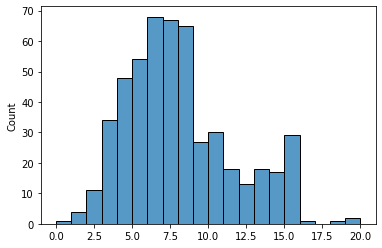

<Figure size 432x288 with 1 Axes>

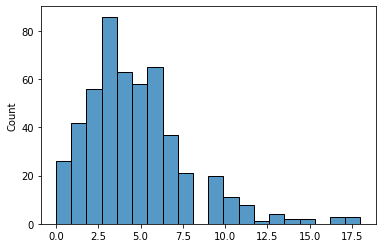

In [8]:
def get_n_words(dic, n: int):
    """Mot de la position n"""
    return [vals[n] for vals in dic.values() if n < len(vals)]


print("Répartitions des longueurs des cartes")
sns.histplot([len(vals) for vals in dict_mine.values()], bins=20)
plt.show()
sns.histplot([len(vals) for vals in dict_futur.values()], bins=20)
plt.show()


## Quelques indicateurs sur les profils des répondants

On commence par récupérer les libellés des questions


In [9]:
df_questions = pd.read_excel("../input/BDD_2022-05-31.xlsx", sheet_name="Questions", parse_dates=False).astype(
    {"Question": "string", "Libellé": "string"}
)
display(df_questions)
print(f"Toutes les questions présentes {set(df_questions['Question']) <= set(df_resp.columns)}")
questions_labels = df_questions.set_index("Question").to_dict()["Libellé"]  # orient="series"


,Question,Libellé
0,Question 1,Travaillez-vous ou avez travaillez pour l’indu...
1,Question 2,"Si oui, quel(s) étai(en)t votre/vos poste(s) ?"
2,Question 3,Depuis combien de temps travaillez-vous ou pen...
3,Question 4,Un membre de votre famille travaille t’il ou a...
4,Question 5,Avez-vous toujours vécu en Nouvelle-Calédonie ?
5,Question 5.1,"Si non, d’où venez-vous ?"
6,Question 6,"Si non, depuis combien de temps vivez-vous en ..."
7,Question 7,"Si non, pourquoi vous êtes vous installé(e) en..."
8,Question 8,Où habitez-vous ? (Le plus précis possible san...
9,Question 8.1,Commune de résidence.


Toutes les questions présentes False


In [10]:
# print(questions_labels["Question 1"])
# print(questions_labels["Question 4"])
def groupby(questions):
    return df_complete.value_counts(subset=questions, sort=False).rename_axis(
        [questions_labels.get(q, q) for q in questions]
    )


display(groupby(["Question 1", "Question 4"]))
display(groupby(["Question 8.1"]))
display(groupby(["GAD", "Question 8.2"]))


Travaillez-vous ou avez travaillez pour l’industrie minière ou métallurgique ?  Un membre de votre famille travaille t’il ou a t’il travaillé pour cette industrie ?
Non                                                                             Non                                                                                     136
                                                                                Oui                                                                                     300
Oui                                                                             Non                                                                                      12
                                                                                Oui                                                                                      55
dtype: int64

Commune de résidence.
Boulouparis                4
Bourail                    7
Dumbéa                    61
Hienghène                 96
Houaïlou                   4
Kaala-Gomen                2
Koné                       7
Koumac                     1
La Foa                     1
Lifou                     10
Maré                       6
Moindou                    1
Mont-Dore                 80
Nouméa                   109
Ouégoa                     4
Paris                      1
Païta                     37
Poindimié                  4
Ponérihouen                2
Pouembout                  3
Pouébo                     3
Poya                       4
Thio                      16
Touho                     11
Voh                        2
Yaté                      30
Île des Pins               1
dtype: int64

GAD   Distinction communes minières ; non-minière et mixte (Nouméa)
10.0  Minière                                                           64
      Mixte                                                             46
      Non minière                                                      121
20.0  Minière                                                           29
      Mixte                                                             54
      Non minière                                                       75
30.0  Minière                                                           13
      Mixte                                                              3
      Non minière                                                       11
40.0  Minière                                                           14
      Mixte                                                              4
      Non minière                                                        7
50.0  Minière                                                           18
      Mixte                                                              7
      Non minière                                                       16
60.0  Minière                                                            7
      Non minière                                                        8
70.0  Minière                                                            1
      Mixte                                                              2
      Non minière                                                        3
80.0  Minière                                                            2
dtype: int64

Histogramme des ages des répondants


<AxesSubplot:xlabel='Question 12', ylabel='Count'>

<Figure size 432x288 with 1 Axes>

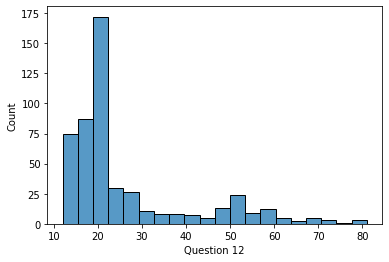

In [11]:
print("Histogramme des ages des répondants")
sns.histplot(df_resp["Question 12"], bins=20)


## Mots les plus communs pour la carte "la mine"

On va segmenter les données en _populations_ (e.g., "moins de 26 ans", "mineur", etc.) selon les attributs et générer un tableau avec :

- en ligne tous les mots énoncés dans les cartes "la mine"
- en colonne, les populations, avec pour chacune :
  - le nombre de fois où le mot a été énoncé par les membres de cette population
  - le nombre de fois "théorique" où le mot serait annoncé si il y avait indépendance des énonciations entre les populations
  - le % de fois où un membre de la population a énoncé le mot
- pour chaque groupe, on calcule ensuite un test du $\chi^2$ pour évaluer l'écart à l'indépendance


In [12]:
LABEL_TOTAL = "Total"
CLEF_TOTAL = (
    "*",
    "*",
    LABEL_TOTAL,
)
all_words_mine = Counter(w for l in dict_mine.values() for w in l)
all_words_futur = Counter(w for l in dict_futur.values() for w in l)

df_population = pd.DataFrame(index=list(all_words_mine.keys()))
df_population[CLEF_TOTAL] = all_words_mine.values()
THRESHOLD = 20
df_population = df_population[df_population[CLEF_TOTAL] >= THRESHOLD]
df_population.sort_values(CLEF_TOTAL, key=op.neg, inplace=True)


def pretty_pvals(x):
    if x < 1e-4:
        return "****"
    if x < 1e-3:
        return "***"
    if x < 1e-2:
        return "**"
    if x < 5e-2:
        return "*"
    return ""


def add_population(filtres, name):
    """Ajout de colonnes sur une population segmentée"""
    observed = []
    expected = []
    chi2 = stats.chi2(len(filtres) - 1)
    for filtre, val in filtres:
        cg = get_cogmaps(df_mine[filtre], cols_mine)
        c = Counter(w for l in cg.values() for w in l)
        print(f"Ajout de la colonne '{name}, {val}', {len(cg)} répondants, {c.total()} énonciations")

        key = (name, val, "Nb.")
        df_population[key] = pd.Series(c)
        df_population[key].fillna(0, inplace=True)
        df_population[key] = df_population[key].astype(int)
        # df_population[f"{name} (% des mots)"] = round(100 * pd.Series(c) / c.total(),2)
        # ici en % ** des répondants**
        df_population[(name, val, "Nb. th.")] = round(df_population[CLEF_TOTAL] * len(cg) / len(df_mine), 2)
        exp = df_population[CLEF_TOTAL].to_numpy() * len(cg) / len(df_mine)
        # df_population[(name, val, "(%)")] = round(100 * pd.Series(c) / len(cg), 2)

        observed.append(df_population[key].to_numpy().reshape(-1, 1))
        # expected.append(df_population[(name, val, "Nb. th.")].to_numpy().reshape(-1, 1))
        expected.append(exp.reshape(-1, 1))

    obs, exp = np.concatenate(observed, axis=1), np.concatenate(expected, axis=1)
    # df_population[(name, "Chi²", "Value")] = np.sum((obs-exp)**2/exp, axis=1)
    chis = np.sum((obs - exp) ** 2 / exp, axis=1)
    # df_population[(name, "Chi²", "p-value")] = chi2.sf(df_population[(name, "Chi²", "Value")])
    p_vals = chi2.sf(chis)
    # df_population[(name, "Chi²", "Significatif")] = [pretty_pvals(v) for v in  df_population[(name, "Chi²", "p-value")]]
    df_population[(name, "Chi²", "Significatif")] = [pretty_pvals(v) for v in p_vals]


def generate_all_filters(col):
    values = df_resp[col].dropna().unique()
    return [(df_resp[col] == value, value) for value in values]


moins_de_26_ans = df_resp["Question 12"] < 26
add_population([(moins_de_26_ans, "Oui"), (~moins_de_26_ans, "Non")], "Age < 26")
add_population(generate_all_filters("Question 13"), "Genre")
# add_population(generate_all_filters("GAD"), "Groupe d'age décénal")
add_population(generate_all_filters("Question 1"), "Travaille dans la mine")
add_population(generate_all_filters("Question 4"), "Famille dans la mine")
add_population(generate_all_filters("Question 5"), "Toujours vécu en NC")
# add_population(generate_all_filters("Question 8.1"), "Commune de résidence")
# pour ça, plutôt faire une AFC
add_population(generate_all_filters("Question 8.2"), "Commune minière")
# df_population=df_population.copy()


# nettoyage final
df_population.fillna(0.0, inplace=True)
df_population.columns = pd.MultiIndex.from_tuples(df_population.columns)
df_population.columns.set_names(["Variable", "Catégorie", "Statistique"], inplace=True)

# THRESHOLD = 10
# display(df_population[df_population[CLEF_TOTAL] >= THRESHOLD])
display(df_population)
# display(df_population[df_population[("Age < 26", "Chi²", "Significatif")].str.startswith("**")])


Ajout de la colonne 'Age < 26, Oui', 364 répondants, 2837 énonciations
Ajout de la colonne 'Age < 26, Non', 144 répondants, 1028 énonciations
Ajout de la colonne 'Genre, Homme', 226 répondants, 1745 énonciations
Ajout de la colonne 'Genre, Femme', 278 répondants, 2090 énonciations
Ajout de la colonne 'Genre, Autre', 4 répondants, 30 énonciations
Ajout de la colonne 'Travaille dans la mine, Non', 438 répondants, 3328 énonciations
Ajout de la colonne 'Travaille dans la mine, Oui', 68 répondants, 520 énonciations
Ajout de la colonne 'Famille dans la mine, Oui', 355 répondants, 2765 énonciations
Ajout de la colonne 'Famille dans la mine, Non', 148 répondants, 1068 énonciations
Ajout de la colonne 'Toujours vécu en NC, Oui', 400 répondants, 2998 énonciations
Ajout de la colonne 'Toujours vécu en NC, Non', 105 répondants, 846 énonciations
Ajout de la colonne 'Commune minière, Minière', 148 répondants, 1116 énonciations
Ajout de la colonne 'Commune minière, Mixte', 116 répondants, 990 énoncia

Variable 
 * 
 Age < 26 
 Genre 
 ... 
 Toujours vécu en NC 
 Commune minière 
 
 
 Catégorie 
 * 
 Oui 
 Non 
 Chi² 
 Homme 
 Femme 
 ... 
 Non 
 Chi² 
 Minière 
 Mixte 
 Non minière 
 Chi² 
 
 
 Statistique 
 Total 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Significatif 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 ... 
 Nb. 
 Nb. th. 
 Significatif 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Significatif 
 
 
 
 
 nickel 
 189 
 151 
 135.43 
 38 
 53.57 
 * 
 81 
 84.08 
 107 
 103.43 
 ... 
 40 
 39.06 
 
 53 
 55.06 
 67 
 43.16 
 68 
 90.41 
 **** 
 
 
 pollution 
 182 
 118 
 130.41 
 64 
 51.59 
 * 
 91 
 80.97 
 88 
 99.60 
 ... 
 41 
 37.62 
 
 61 
 53.02 
 41 
 41.56 
 80 
 87.06 
 
 
 
 économie 
 112 
 78 
 80.25 
 34 
 31.75 
 
 49 
 49.83 
 61 
 61.29 
 ... 
 26 
 23.15 
 
 39 
 32.63 
 42 
 25.57 
 31 
 53.57 
 **** 
 
 
 camion 
 104 
 92 
 74.52 
 12 
 29.48 
 *** 
 41 
 46.27 
 61 
 56.91 
 ... 
 6 
 21.50 
 *** 
 22 
 30.30 
 21 
 23.75 
 61 
 49.75 
 
 
 
 travail 
 100 
 74 
 71.65 
 26 
 28.35 
 
 41 
 44.49 
 57 
 54.72 
 ... 
 30 
 20.67 
 * 
 28 
 29.13 
 23 
 22.83 
 49 
 47.83 
 
 
 
 environnement 
 100 
 60 
 71.65 
 40 
 28.35 
 ** 
 47 
 44.49 
 53 
 54.72 
 ... 
 25 
 20.67 
 
 30 
 29.13 
 34 
 22.83 
 36 
 47.83 
 * 
 
 
 emploi 
 97 
 68 
 69.50 
 29 
 27.50 
 
 50 
 43.15 
 45 
 53.08 
 ... 
 23 
 20.05 
 
 29 
 28.26 
 31 
 22.15 
 37 
 46.40 
 
 
 
 usine 
 89 
 83 
 63.77 
 6 
 25.23 
 **** 
 33 
 39.59 
 56 
 48.70 
 ... 
 15 
 18.40 
 
 18 
 25.93 
 21 
 20.32 
 50 
 42.57 
 
 
 
 argent 
 74 
 42 
 53.02 
 32 
 20.98 
 ** 
 37 
 32.92 
 37 
 40.50 
 ... 
 15 
 15.30 
 
 29 
 21.56 
 13 
 16.90 
 31 
 35.40 
 
 
 
 richesse 
 74 
 48 
 53.02 
 26 
 20.98 
 
 33 
 32.92 
 40 
 40.50 
 ... 
 21 
 15.30 
 
 16 
 21.56 
 22 
 16.90 
 36 
 35.40 
 
 
 
 montagne 
 74 
 58 
 53.02 
 16 
 20.98 
 
 25 
 32.92 
 49 
 40.50 
 ... 
 8 
 15.30 
 * 
 19 
 21.56 
 14 
 16.90 
 41 
 35.40 
 
 
 
 terre 
 73 
 60 
 52.31 
 13 
 20.69 
 * 
 34 
 32.48 
 39 
 39.95 
 ... 
 10 
 15.09 
 
 13 
 21.27 
 9 
 16.67 
 51 
 34.92 
 *** 
 
 
 minerai 
 65 
 59 
 46.57 
 6 
 18.43 
 *** 
 23 
 28.92 
 41 
 35.57 
 ... 
 9 
 13.44 
 
 25 
 18.94 
 15 
 14.84 
 25 
 31.09 
 
 
 
 exploitation 
 65 
 59 
 46.57 
 6 
 18.43 
 *** 
 32 
 28.92 
 32 
 35.57 
 ... 
 16 
 13.44 
 
 23 
 18.94 
 14 
 14.84 
 28 
 31.09 
 
 
 
 destruction 
 60 
 33 
 42.99 
 27 
 17.01 
 ** 
 24 
 26.69 
 35 
 32.83 
 ... 
 17 
 12.40 
 
 21 
 17.48 
 11 
 13.70 
 28 
 28.70 
 
 
 
 ressource 
 56 
 48 
 40.13 
 8 
 15.87 
 * 
 25 
 24.91 
 30 
 30.65 
 ... 
 11 
 11.57 
 
 16 
 16.31 
 21 
 12.79 
 19 
 26.79 
 * 
 
 
 sln 
 54 
 46 
 38.69 
 8 
 15.31 
 * 
 21 
 24.02 
 33 
 29.55 
 ... 
 13 
 11.16 
 
 16 
 15.73 
 15 
 12.33 
 23 
 25.83 
 
 
 
 conflit 
 50 
 40 
 35.83 
 10 
 14.17 
 
 20 
 22.24 
 28 
 27.36 
 ... 
 13 
 10.33 
 
 21 
 14.57 
 9 
 11.42 
 20 
 23.92 
 
 
 
 déforestation 
 41 
 34 
 29.38 
 7 
 11.62 
 
 23 
 18.24 
 18 
 22.44 
 ... 
 8 
 8.47 
 
 11 
 11.94 
 13 
 9.36 
 17 
 19.61 
 
 
 
 caillou 
 38 
 36 
 27.23 
 2 
 10.77 
 ** 
 10 
 16.91 
 28 
 20.80 
 ... 
 4 
 7.85 
 
 10 
 11.07 
 10 
 8.68 
 18 
 18.18 
 
 
 
 exportation 
 31 
 29 
 22.21 
 2 
 8.79 
 ** 
 11 
 13.79 
 19 
 16.96 
 ... 
 5 
 6.41 
 
 10 
 9.03 
 10 
 7.08 
 11 
 14.83 
 
 
 
 développement 
 30 
 21 
 21.50 
 9 
 8.50 
 
 18 
 13.35 
 11 
 16.42 
 ... 
 11 
 6.20 
 * 
 10 
 8.74 
 8 
 6.85 
 12 
 14.35 
 
 
 
 terre rouge 
 30 
 25 
 21.50 
 5 
 8.50 
 
 10 
 13.35 
 20 
 16.42 
 ... 
 5 
 6.20 
 
 12 
 8.74 
 6 
 6.85 
 12 
 14.35 
 
 
 
 nature 
 28 
 10 
 20.06 
 18 
 7.94 
 **** 
 11 
 12.46 
 16 
 15.32 
 ... 
 5 
 5.79 
 
 9 
 8.16 
 2 
 6.39 
 17 
 13.39 
 
 
 
 métal 
 24 
 23 
 17.20 
 1 
 6.80 
 ** 
 12 
 10.68 
 11 
 13.13 
 ... 
 3 
 4.96 
 
 4 
 6.99 
 2 
 5.48 
 18 
 11.48 
 * 
 
 
 extraction 
 22 
 18 
 15.76 
 4 
 6.24 
 
 7 
 9.79 
 15 
 12.04 
 ... 
 8 
 4.55 
 
 9 
 6.41 
 7 
 5.02 
 5 
 10.52 
 
 
 
 goro 
 21 
 17 
 15.05 
 

In [13]:
today = date.today().strftime("%Y-%m-%d")
output = Path("../output_v2")
output.mkdir(parents=True, exist_ok=True)
df_population.to_excel(output / f"analyse_par_population-{today}.xlsx")


## Complétude du thésaurus


In [14]:
df_thesaurus = pd.read_excel(FILENAME, sheet_name="Thésaurus_2")
concepts = df_thesaurus.columns.to_list()


thesaurus = {
    clean(key): [clean(val) for val in vals if val is not np.nan]
    for key, vals in df_thesaurus.to_dict(orient="list").items()
}

print(f"Nombre de concepts dans le thésaurus {len(thesaurus)}")
print(f"Nombre de mots classés dans le thésaurus {sum(len(vals) for vals in thesaurus.values())}")


Nombre de concepts dans le thésaurus 38
Nombre de mots classés dans le thésaurus 1086


In [15]:
all_words_thesaurus = [val for vals in thesaurus.values() for val in vals]
print(f"Nombre de mots du thésaurus = {[len(vals) for vals in thesaurus.values()]}")
print(f"Nombre total de mots du thésaurus = {len(all_words_thesaurus)}")
print(f"Nombre de mots du thésaurus sans doublons = {len(set(all_words_thesaurus))}")
print(f"Doublons dans le thésaurus : {len(all_words_thesaurus) != len(set(all_words_thesaurus))}")


Nombre de mots du thésaurus = [39, 57, 10, 29, 38, 23, 66, 11, 18, 50, 25, 51, 147, 89, 20, 2, 6, 43, 38, 8, 87, 13, 30, 43, 1, 9, 12, 10, 7, 8, 9, 3, 18, 9, 7, 7, 20, 23]
Nombre total de mots du thésaurus = 1086
Nombre de mots du thésaurus sans doublons = 1069
Doublons dans le thésaurus : True


In [16]:
print("Mots avec occurrences multiples dans le thésaurus, pour chaque, la liste des concepts où il apparait")
occ_mutiples = {
    mot: [concept for concept, vals in thesaurus.items() if mot in vals]
    for mot, occ in Counter(all_words_thesaurus).items()
    if occ > 1
}
display(occ_mutiples)


Mots avec occurrences multiples dans le thésaurus, pour chaque, la liste des concepts où il apparait


{
    'corruption': ['avis péjoratifs et interactions négatives'],
    'lagon': ['ressources marines'],
    'honneur': ['valeurs sociales et interactions positives'],
    'liens': ['valeurs sociales et interactions positives', 'territoire'],
    'caillou': ['territoire', 'ressource nickel'],
    'foncier': ['territoire'],
    'prospérité': ['territoire', 'avantage-bénéfice économique et financier'],
    'intégration': ['territoire', 'métiers dans le secteur du nickel'],
    'epuisement': ['epuisement des ressources naturelles', 'ressource nickel'],
    'travail': [
        'avantage-bénéfice économique et financier',
        'secteur extractif et  industriel du nickel',
        'ressource nickel'
    ],
    'voiture': [
        'avantage-bénéfice économique et financier',
        "pouvoir d'achat et évolution des conditions matérielles de vie"
    ],
    'rivière rouge': [
        'paysage minier',
        'dégradation-impact environnemental négatif'
    ],
    'métier à risque': ['secteur extractif et  industriel du nickel'],
    'fabrication': [
        'secteur extractif et  industriel du nickel',
        'vocabulaire technique lié à la métallurgie'
    ],
    'métal rare': ['ressource nickel'],
    'problème': ['termes négatifs']
}

In [17]:
mots_mine_sans_concept = set(all_words_mine) - set(all_words_thesaurus)
print(f"Il y a {len(mots_mine_sans_concept)} mots des cartes '{LABEL_MINE}' qui ne sont pas dans le thésaurus.")
print("On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) ")
mots_mine_sans_concept_pos = {
    mot: [num for num, mots in dict_mine.items() if mot in mots] for mot in mots_mine_sans_concept
}
display(mots_mine_sans_concept_pos)


Il y a 263 mots des cartes 'la mine et le nickel' qui ne sont pas dans le thésaurus.
On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) 


{
    'engins': [434, 463, 464, 487, 496],
    'usines': [454, 479, 484, 508],
    'camions': [450, 451, 452, 470, 475, 479, 481, 484, 499, 500, 502],
    'crayon': [101, 148, 243],
    'bateau': [61, 114, 140, 183, 258, 276, 323, 326, 386, 456, 483, 494],
    'alarme': [482],
    'résidu': [269],
    'cargaison': [485],
    'le fer': [455, 477],
    'monsieur': [456],
    'milieu': [84],
    'couleur': [489],
    'car': [436],
    'argents': [502, 506],
    'découvertes incroyables': [454],
    'gueule noire': [319],
    'casier': [474],
    'four géant pour faire chauffer le nickel': [467],
    'porte d’entrée': [9],
    'métal rares': [96],
    'détruit': [459],
    'plus de présence humaine': [490],
    'échantillon': [264],
    'moyen de transport': [483],
    'une pierre riche': [498],
    'lourd': [341],
    'détruit le lagon': [506],
    "vol d'argent": [506],
    'déforestations': [502],
    'échec': [381],
    'énergie fossile': [254, 290],
    "vente d'objet en métal": [454],
    'métaux': [468],
    'fin du monde': [494],
    'envié': [165],
    'la pierre (le caillou)': [486],
    'objets': [437],
    'couler': [448],
    'récolte': [462],
    'poisson': [51],
    'tapis roulants': [476],
    'condition de vie': [30, 260],
    'promesse d’embauche': [248],
    'plus de métal': [490],
    'pierres précieuses': [454],
    'perturbation': [356],
    'espèce endémique': [235],
    'aliments': [495],
    'fer rubané': [152],
    'kilogramme': [437],
    'mine d’or': [65],
    'épuisant': [199],
    'assiette': [383],
    'conflit': [
        26,
        33,
        36,
        37,
        46,
        76,
        87,
        89,
        113,
        116,
        119,
        120,
        123,
        129,
        135,
        155,
        160,
        164,
        167,
        176,
        179,
        185,
        201,
        202,
        204,
        206,
        208,
        210,
        223,
        224,
        225,
        231,
        235,
        239,
        240,
        249,
        252,
        278,
        279,
        301,
        307,
        309,
        335,
        352,
        367,
        368,
        370,
        396,
        399,
        506
    ],
    'creuser la terre': [466],
    "plus d'air": [490],
    'mines partout': [450],
    'activité économique': [375],
    'terre coutumière': [233, 328, 343],
    'bâteaux': [453, 475],
    'éboulement': [101, 125, 167, 249, 342, 355],
    'électricité': [254, 378],
    'elle est grande': [452],
    'emploi non-qualifié': [150],
    'couteaux': [437],
    'construire des choses': [472],
    'puissance': [51],
    'les évènements': [267],
    'revendu et fondu': [436],
    'force': [364],
    'métal': [
        92,
        131,
        177,
        238,
        261,
        302,
        325,
        326,
        344,
        383,
        437,
        446,
        460,
        461,
        463,
        464,
        475,
        479,
        485,
        488,
        490,
        495,
        498,
        500
    ],
    'nouméa': [495],
    'pollution de la nature': [508],
    'piscine': [436],
    'les roches': [466],
    'lave': [445, 448, 463],
    'un nouveau monde': [490],
    'ressource épuisable': [109, 249],
    'usine nord': [115],
    'bien payé': [436],
    "chiffre d'affaire": [468],
    'développement d’activités': [93],
    'échelle': [354],
    'charcreuse': [474],
    'dégradation du pays': [490],
    'le chrome': [455],
    'travaux tous les jours': [508],
    'internationale': [485],
    'remorqueur': [482],
    'planter': [380],
    'articulé': [474],
    'destruction du lagon': [475],
    "plus beaucoup d'arbres": [493],
    'chef': [436],
    'avancé': [325],
    'long': [81],
    'pelleteuse': [446, 451, 474, 503],
    'machines': [454, 456, 484, 488],
    'patrons': [456],
    'pas durable': [353],
    'tapis (serpentine)': [493],
    'travailleurs': [476],
    'entrepôt': [464],
    'solidarité': [439],
    'sud': [67, 117, 403],
   

In [18]:
mots_futur_sans_concept = set(all_words_futur) - set(all_words_thesaurus)
print(f"Il y a {len(mots_futur_sans_concept)} mots des cartes '{LABEL_FUTUR}' qui ne sont pas dans le thésaurus :")
print("On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) ")
mots_futur_sans_concept_pos = {
    mot: [num for num, mots in dict_futur.items() if mot in mots] for mot in mots_futur_sans_concept
}
display(mots_futur_sans_concept_pos)


Il y a 324 mots des cartes 'la mine dans le futur' qui ne sont pas dans le thésaurus :
On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) 


{
    'dominance': [51],
    "problème d'usine": [453],
    'beaucoup de nickel utilisé': [490],
    'soleil': [470],
    'point fort': [111],
    "y'auras plus rien": [408],
    'perdre': [124],
    'des centrals': [464],
    'kanaky dawany': [333],
    'âge d’or': [29],
    'échec': [63, 388],
    'camion plus adapté': [479],
    'développer': [187, 218],
    'développé': [321, 325],
    'esprit d’équipe': [132],
    'économie circulaire': [74],
    'économie durable': [93],
    'conflit': [
        14,
        36,
        48,
        52,
        75,
        81,
        83,
        85,
        88,
        110,
        116,
        119,
        123,
        129,
        137,
        160,
        166,
        179,
        185,
        210,
        219,
        249,
        332,
        333,
        338,
        348,
        396,
        506
    ],
    'respect environnemental': [174],
    'plus terre abîmée': [480],
    'écologique': [154, 156, 165, 198, 309, 321, 365],
    'nouveaux engins': [481],
    'emploi non-qualifié': [150],
    'disparition montagne': [476],
    'changement total': [234],
    "il n'y aura plus de bateaux": [477],
    'efficace': [162],
    'beaucoup de personnes': [477],
    'étude d’impact': [224],
    'incertain': [29, 42, 121, 189, 363],
    'plus de végétation': [485],
    'plus de mines dans le monde': [454],
    'machines': [488],
    'épuisé': [73, 114, 117, 213, 248, 249, 254, 343],
    'disparition de la montagne': [480],
    "main d'œuvre étrangère": [405],
    'égalité': [208],
    'habitats': [475],
    'transportation du nickel par des cabines volantes': [464],
    'chargements': [475],
    'camion électronique': [484],
    'terre cultivable': [413],
    '3ème guerre mondiale': [494],
    'stable': [321, 357],
    'économie': [
        13,
        24,
        32,
        53,
        57,
        64,
        71,
        85,
        87,
        88,
        91,
        94,
        97,
        123,
        132,
        152,
        164,
        172,
        184,
        193,
        199,
        201,
        204,
        209,
        217,
        225,
        229,
        234,
        249,
        251,
        257,
        279,
        281,
        283,
        291,
        293,
        294,
        295,
        313,
        315,
        324,
        331,
        332,
        338,
        343,
        358,
        367,
        371,
        373,
        387,
        393,
        394,
        395,
        398
    ],
    'ouverture': [179],
    'tubercule': [413],
    'air polluée': [335],
    'automatisé': [252, 389],
    'plusieurs mines comme la sln': [455],
    'mine énergétique': [106],
    'matériau alternatif': [36],
    'actif': [148],
    "il n'y aura plus de montagne": [459, 477],
    'plus aucune exploitation': [501],
    'évolution': [
        20,
        30,
        52,
        60,
        70,
        81,
        82,
        85,
        113,
        117,
        147,
        157,
        160,
        217,
        296,
        377
    ],
    'moins de végétation': [490],
    'manne financière': [407],
    'etat des routes': [423],
    'intérêt': [185],
    'pelleteuse volante': [446],
    'penser plus tard': [432],
    'électronique': [239],
    'technologie avancée': [471],
    'irréel': [319],
    'de plus en plus de mines': [455],
    "peut être qu'il n'y aura plus d'indépendance pour le nickel": [451],
    'exploitation sans limite': [490],
    'moins riche': [498],
    'plus de camions': [477, 478],
    'pyrométallurgique': [93],
    'proies faciles': [437],
    'plus de chaleur': [484],
    'accroissement': [84],
    'engins électriques': [464, 487],
    'épuisement': [
        3,
        31,
        81,
        82,
        85,
        88,
        90,
        100,
        129,
        139,
        148,
        177,
        178,
        184,
        185,
        219,
        226,
        259,
        273,
        281,
        283,
        292,
        293,
        309,
        31

In [19]:
mots_thesaurus_sans_enonciation = set(all_words_thesaurus) - set(all_words_mine) - set(all_words_futur)
print(f"Il y a {len(mots_thesaurus_sans_enonciation)} mots du thésaurus qui n'apparaissent dans aucune carte")
display(mots_thesaurus_sans_enonciation)


Il y a 75 mots du thésaurus qui n'apparaissent dans aucune carte


{
    'drône',
    'economie circulaire',
    'economie durable',
    'energie fossile',
    'evolution technologique',
    'conditions de travail',
    'equité',
    "respect de l'environnement",
    'equipe',
    'tranquilité',
    'etroit',
    "promesse d'embauche",
    'eloignement',
    'marché (économique)',
    'conditions de vie',
    'egoïste',
    'economie verte',
    'energie non renouvelable',
    'matérieu alternatif',
    'prélévement',
    'erosion',
    "mine d'or",
    'pertubation',
    'echantillon',
    'echange international',
    'dédommagment',
    'echec',
    'mine énergetique',
    'scories',
    'air pollué',
    'ecologie',
    'ecoresponsable',
    "âge d'or",
    "etude d'impact",
    'ecole',
    'economie sociale et solidaire',
    'energie verte',
    'avancer',
    'echange',
    'transition énergetique',
    'electricité',
    'epuisant',
    'nécessaire',
    'compliqué',
    'inégalités',
    'education',
    'personnel',
    'evolution écologique',
    'impact mauvais',
    "esprit d'équipe",
    'non renouvelable',
    "assurance d'emploi",
    "engin d'extraction",
    'energie durable',
    'emploi non qualifié',
    'interêt commun',
    'alternative énergetique',
    'electronique',
    'les evénements',
    'métal rare',
    'marché (communal)',
    'energie renouvelable',
    'résidus',
    'conditions',
    'mineral',
    'remonté de gaz',
    'ecosystème',
    'sous famille de dégradation_impact environ ?',
    'ephémère',
    'envier',
    'rationalisation',
    'echelle',
    'economiser la ressource',
    'economie fictive',
    'egalité'
}

## Analyse des correspondances


In [22]:
ROW_THRESHOLD = 20
COL_THRESHOLD = 100


def gen_ca_dataset(attribut):

    cats = df_complete[attribut].dropna().unique()
    cats_filters = {value: (df_resp[attribut] == value) for value in cats}

    # gad_filters[80.0].index[gad_filters[80.0]].to_list() # to_numpy().nonzero()

    df = pd.DataFrame(index=all_words_mine)
    # dict_mine
    # gad_filters.keys()
    for group in sorted(cats_filters.keys()):
        ids = cats_filters[group].index[cats_filters[group]].to_list()
        cogs = Counter(mot for num, mots in dict_mine.items() if num in ids for mot in mots)
        # print(f"Groupe {group} :  {len(ids)} individus, {len(cogs)} mots énoncés")
        df[group] = pd.Series(cogs)

    df = df.fillna(0).astype(int)
    df.columns.name = questions_labels.get(attribut, attribut)
    df.index.name = "Mot énoncé"
    # df_gad

    row_margin = df.sum(axis=1)
    col_margin = df.sum(axis=0)

    # les mots énoncés au moins 20x pour les classes qui énoncent au moins 100 mots
    return df.loc[row_margin > ROW_THRESHOLD, col_margin > COL_THRESHOLD]


# gen_ca_dataset("Question 8.2")

GAD,10.0,20.0,30.0,40.0,50.0
Mot énoncé,,,,,
argent,28,18,8,5,11
caillou,26,11,1,0,0
camion,65,31,2,3,3
conflit,23,19,2,2,4
destruction,17,20,6,3,7
déforestation,23,13,3,0,2
développement,9,14,1,1,3
emploi,31,43,6,5,10
engin,7,7,3,2,1


<Figure size 1152x864 with 1 Axes>

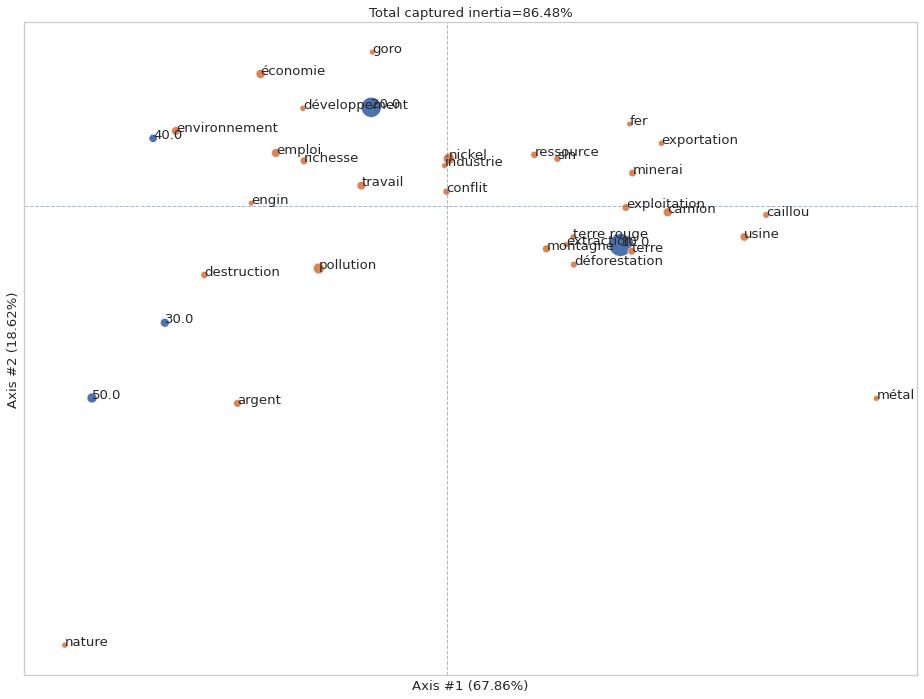

Commune de résidence.,Dumbéa,Hienghène,Mont-Dore,Nouméa,Païta,Yaté
Mot énoncé,,,,,,
argent,8,14,10,11,5,9
caillou,5,7,8,10,3,0
camion,12,33,10,18,2,2
conflit,9,1,14,8,6,6
destruction,10,9,11,10,3,1
déforestation,3,6,11,13,3,0
développement,7,2,3,6,1,5
emploi,12,1,17,29,12,5
engin,2,2,5,5,1,0


<Figure size 1152x864 with 1 Axes>

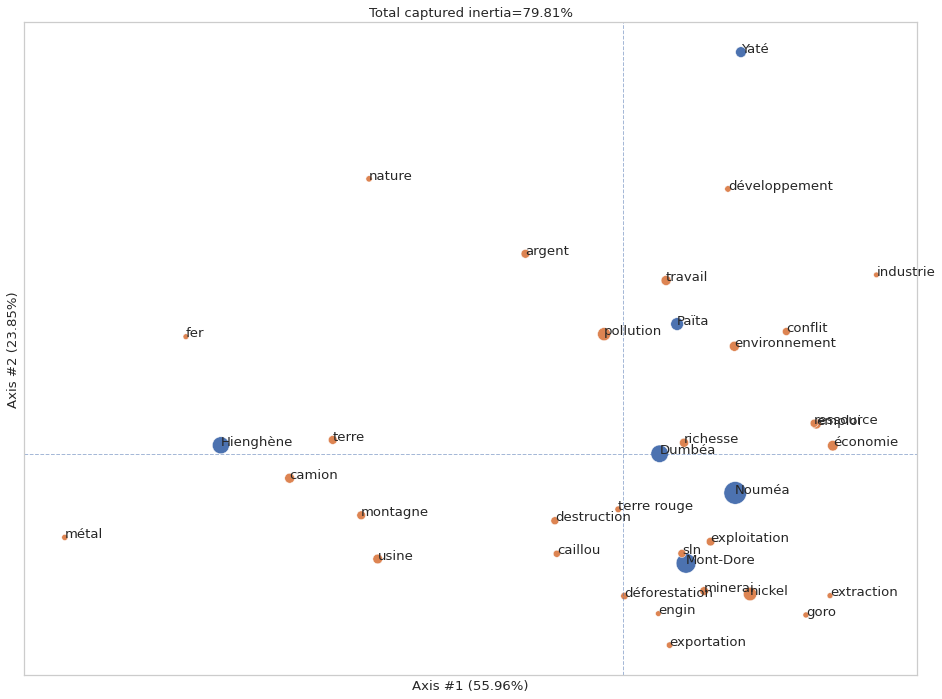

Distinction communes minières ; non-minière et mixte (Nouméa),Minière,Mixte,Non minière
Mot énoncé,,,
argent,29,13,31
caillou,10,10,18
camion,22,21,61
conflit,21,9,20
destruction,21,11,28
déforestation,11,13,17
développement,10,8,12
emploi,29,31,37
engin,9,6,6


<Figure size 1152x864 with 1 Axes>

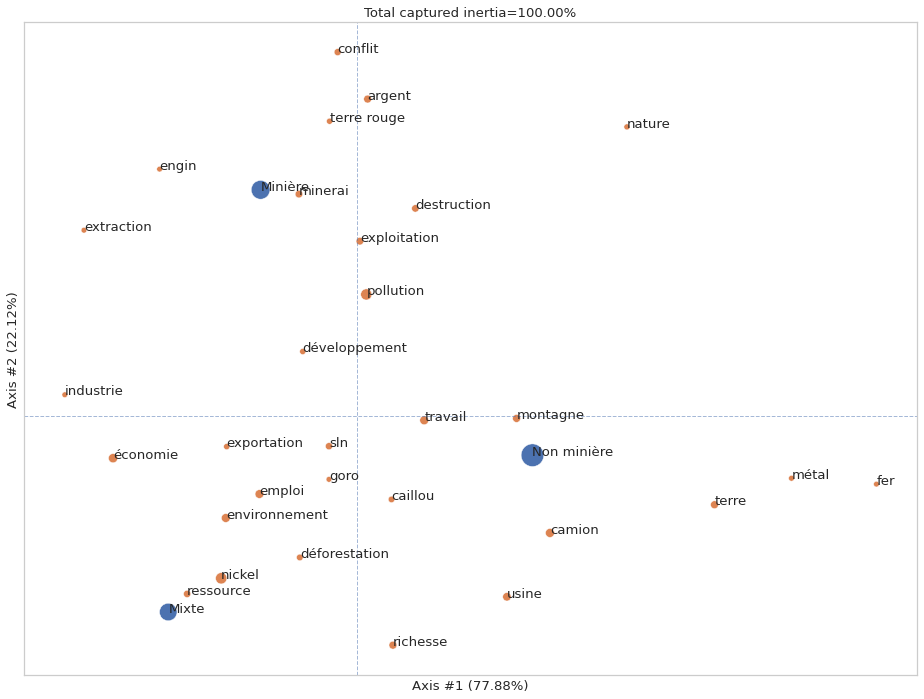

In [24]:
sns.set_theme(style="whitegrid", font_scale=1.10, rc={"figure.figsize": (16, 12)})
ca = CA(42)

for attribut in ["GAD", "Question 8.1", "Question 8.2"]:
    ref = gen_ca_dataset(attribut)
    display(ref.sort_index())
    ca.fit(ref)
    # ca.plot(coords=("principal", "standard"))
    # plt.show()
    # ca.plot(coords=("standard", "principal"))
    # plt.show()
    ca.plot(coords=("principal", "principal"), legend=None)
    plt.show()
